<a href="https://colab.research.google.com/github/SuperMusey/FoundationOfPrivacy/blob/main/MIA_phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIA FOR Finetuned LLM

In [1]:
# update the downloading command as my LFS runs out so cannot directly clone model.safetensors
%cd /content

!rm -rf /content/Project_phase1

# skip LFS!!!: as my LFS bandwith run out
!GIT_LFS_SKIP_SMUDGE=1 git clone https://github.com/2020pyfcrawl/Project_phase1.git

# download the model.safetensors: this enables faster download, you may also upload in colab but it's slower
# 1. download the model.safetensors from repo webpage
# 2. upload that into your google drive
# 3. copy link to share and replace the <...> with your link to download
# 4. run the command below
!gdown --fuzzy https://drive.google.com/file/d/1v9WCSMHghFBZqMkJp3XsElXey5zsCp_G/view?usp=sharing -O /content/Project_phase1/models/gpt2_phase1/

%cd /content/Project_phase1


/content
Cloning into 'Project_phase1'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 49 (delta 17), reused 31 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 1.74 MiB | 18.03 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Downloading...
From (original): https://drive.google.com/uc?id=1v9WCSMHghFBZqMkJp3XsElXey5zsCp_G
From (redirected): https://drive.google.com/uc?id=1v9WCSMHghFBZqMkJp3XsElXey5zsCp_G&confirm=t&uuid=85845f76-fa4d-41b1-b5c8-5a89c513f351
To: /content/Project_phase1/models/gpt2_phase1/model.safetensors
100% 498M/498M [00:09<00:00, 52.8MB/s]
/content/Project_phase1


In [2]:
# check here, model.safetensors should be 475M, if not, delete it and re-download
!ls -lah ./models/gpt2_phase1/

total 480M
drwxr-xr-x 2 root root 4.0K Oct 14 15:37 .
drwxr-xr-x 3 root root 4.0K Oct 14 15:37 ..
-rw-r--r-- 1 root root  899 Oct 14 15:37 config.json
-rw-r--r-- 1 root root  154 Oct 14 15:37 generation_config.json
-rw-r--r-- 1 root root 446K Oct 14 15:37 merges.txt
-rw-r--r-- 1 root root 475M Oct 12 17:38 model.safetensors
-rw-r--r-- 1 root root  131 Oct 14 15:37 special_tokens_map.json
-rw-r--r-- 1 root root  507 Oct 14 15:37 tokenizer_config.json
-rw-r--r-- 1 root root 3.4M Oct 14 15:37 tokenizer.json
-rw-r--r-- 1 root root 780K Oct 14 15:37 vocab.json


### Variables and libraries

In [ ]:
# install the required libraries if you have not done so (on you local machine or GPU server)
# you may not need to run this if you use colab as they are pre-installed, but you can always do it.
%pip install -r requirements.txt

In [3]:
import os, math, argparse
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION", "1")

import torch
import numpy as np
from datasets import load_from_disk
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import roc_auc_score, roc_curve, auc as _auc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datasets import Dataset

In [ ]:
%pwd

'/content/Project_phase1'

In [17]:
# global variable, check the current position to adjust the path
target_model_dir = "./models/gpt2_phase1"
data_dir = "./data/wiki_json"
batch_size = 25

# you may change block size if you like (max length for the tokenizer below)
block_size = 512

### Data pre-processing

In [18]:
def tokenize_dataset(ds, tok, max_len):
    ds = ds.filter(lambda ex: ex.get("text", None) and len(ex["text"].strip()) > 0)

    def _map(ex):
        out = tok(ex["text"], truncation=True, padding=True, max_length=max_len, return_attention_mask=True)
        out["labels"] = out["input_ids"].copy()
        return out

    ds = ds.map(_map, batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

def _read_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

In [19]:
# for tests, you may only load a part of the data to save time while implementing,
# as running all 2000 samples on CPU may be slow, but not a problem here for GPU

# load test data
data_dir = Path(data_dir)
test_path = data_dir / "test.json"
test_items = _read_json(test_path)
ds_test = Dataset.from_dict({"text": test_items})

# tokenizer the test data
tokenizer = AutoTokenizer.from_pretrained(target_model_dir, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"

ds_test = tokenize_dataset(ds_test, tokenizer, block_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# you may load the model using the code:
# model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [7]:
model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)

### MIA

Implement your attack here!

In [20]:
@torch.no_grad()
def your_attack(model, dataloader, device):
    model.eval()
    scores = []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Get model outputs
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Only consider previous token and not next ones
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention = attention_mask[..., 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')

        for i in range(input_ids.size(0)):
            sample_logits = shift_logits[i]
            sample_labels = shift_labels[i]
            sample_attention = shift_attention[i]

            token_losses = loss_fct(sample_logits, sample_labels)

            valid_tokens = sample_attention.sum()
            if valid_tokens > 0:
                sample_loss = (token_losses * sample_attention).sum() / valid_tokens
            else:
                sample_loss = token_losses.mean()
            scores.append(-sample_loss.item())

    return scores
scores_test = your_attack(model, dl_test, device)

### Visualization

In [21]:
# load the label here to compute the performance, you will only have full access to the label in phase 1 as a warm-up
label_path = data_dir / "test_label.json"
label_items = _read_json(label_path)

y_true = np.array(label_items)
scores = np.array(scores_test)
fpr, tpr, thr = roc_curve(y_true, scores)
auc_val = roc_auc_score(y_true, scores)
print(auc_val) # area under curve

# some tpr fpr
print(max(tpr[fpr < 0.01])) # TPR @ 0.01FPR
print(max(tpr[fpr < 0.05])) # TPR @ 0.05FPR
# report this three metrics in your report!!

0.714874
0.033
0.192


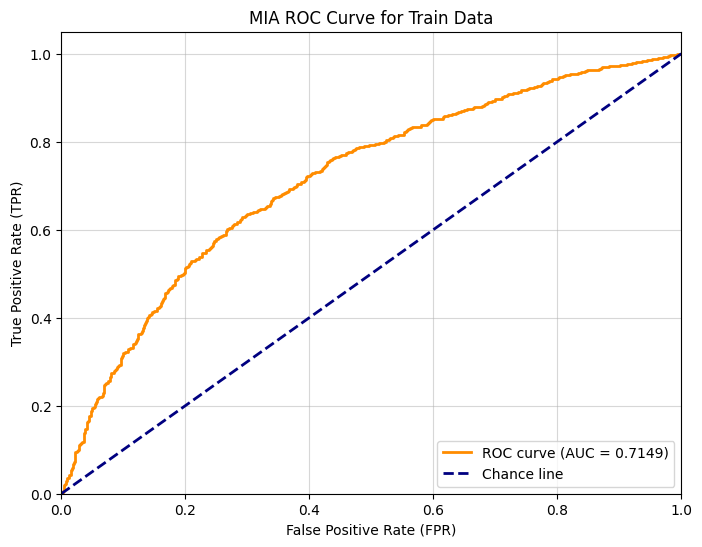

In [22]:
# draw ROC curve and attach the figure in the report
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'MIA ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()